In [ ]:
import numpy as np
import random
import copy
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle
import cv2
import os
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

### Create clients from two classes of data

In [ ]:
def get_clients(class1, class2, n_clients = 3):

  clients_X = []
  clients_y = []

  clientsXtest = []
  clientsYtest = []

  clusters_1 = KMeans(n_clusters=n_clients, random_state=0).fit_predict(class1)
  clusters_2 = KMeans(n_clusters=n_clients, random_state=0).fit_predict(class2)

  for i in range(n_clients):

    X_train0, X_test0, y_train0, y_test0 = train_test_split(class1[clusters_1 == i],np.zeros((class1[clusters_1 == i].shape[0],)),test_size=0.2)
    X_train1, X_test1, y_train1, y_test1 = train_test_split(class2[clusters_2 == i],np.ones((class2[clusters_2 == i].shape[0],)),test_size=0.2)

    clients_X.append([X_train0, X_train1])
    clients_y.append([y_train0, y_train1])

    clientsXtest.extend([X_test0,X_test1])
    clientsYtest.extend([y_test0,y_test1])

  X_test = np.concatenate(clientsXtest,axis=0)
  y_test = np.concatenate(clientsYtest,axis=0)

  return clients_X,clients_y,X_test,y_test

In [ ]:
def get_total_from_clients(clients_X,clients_y):
  x_train0 = [i[0] for i in clients_X]
  x_train0 = np.concatenate(x_train0, axis=0)
  x_train1 = [i[1] for i in clients_X]
  x_train1 = np.concatenate(x_train1, axis=0)
  y_train0 = [i[0] for i in clients_y]
  y_train0 = np.concatenate(y_train0, axis=0)
  y_train1 = [i[1] for i in clients_y]
  y_train1 = np.concatenate(y_train1, axis=0)

  return ([x_train0,x_train1],[y_train0,y_train1])    

# svm

In [ ]:
class SVM:

  def __init__(self, X_train, y_train, X_test, y_test, val=True, val_type='k_fold', k=5, opt='batch_GD', batch_size = 30, n_iters=1000, learning_rate=0.001, lambda_param=0.01):

    self.lr = learning_rate
    self.lambda_param = lambda_param
    self.n_iters = n_iters

    self.X_train = X_train
    self.y_train = y_train

    self.X_test = X_test
    self.y_test = y_test

    self.val = val
    self.val_type=val_type
    self.k=k

    self.opt = opt
    self.batch_size = batch_size

    self.w = np.array([])
    self.b = None

  def grad(self,x,y):
    if y * (np.dot(x, self.w) - self.b) >= 1:
      dw = self.lr * (2 * self.lambda_param * self.w)
      db = 0
    else:
      dw = self.lr * (2 * self.lambda_param * self.w - np.dot(x, y))
      db = self.lr * y

    return (dw,db)
  

  def stochastic_GD(self, X_train, y_train, X_val=None, y_val=None):
    n_samples, n_features = X_train.shape  
    y_ = np.where(y_train <= 0, -1, 1)
          
    if self.w.size == 0 and self.b is None :
      self.w = np.zeros(n_features)
      self.b = 0

    w_best = np.zeros(n_features)
    b_best = 0

    acc_list = [] 
    for i in range(0,self.n_iters):
      for idx, x_i in enumerate(X_train):
        dw,db = self.grad(x_i,y_[idx])
        self.w -= dw
        self.b -= db
    
      if i%10 == 0 and self.val:
        approx_w = np.dot(X_val, self.w) - self.b
        approx_w = np.sign(approx_w)
        res_w = np.where(approx_w<0, 0, approx_w)

        approx_w_best = np.dot(X_val, w_best) - b_best
        approx_w_best = np.sign(approx_w_best)
        res_w_best = np.where(approx_w_best<0, 0, approx_w_best)
            
        if (accuracy_score(y_val, res_w_best) < accuracy_score(y_val, res_w)):
          w_best = copy.deepcopy(self.w)
          b_best = copy.deepcopy(self.b)


  def batch_GD(self, X_train, y_train, X_val=None, y_val=None):
      n_samples, n_features = X_train.shape  
      y_ = np.where(y_train <= 0, -1, 1)
            
      if self.w.size == 0 and self.b is None :
        self.w = np.zeros(n_features)
        self.b = 0

      w_best = np.zeros(n_features)
      b_best = 0

      acc_list = [] 
      for i in range(0,self.n_iters):
        dw_sum=0
        db_sum=0
        for idx, x_i in enumerate(X_train):
          dw,db = self.grad(x_i,y_[idx])
          dw_sum+=dw
          db_sum+=db
        self.w -= (dw_sum/n_samples)
        self.b -= (db_sum/n_samples)
      
        if i%10 == 0 and self.val:
          approx_w = np.dot(X_val, self.w) - self.b
          approx_w = np.sign(approx_w)
          res_w = np.where(approx_w<0, 0, approx_w)

          approx_w_best = np.dot(X_val, w_best) - b_best
          approx_w_best = np.sign(approx_w_best)
          res_w_best = np.where(approx_w_best<0, 0, approx_w_best)
              
          if (accuracy_score(y_val, res_w_best) < accuracy_score(y_val, res_w)):
            w_best = copy.deepcopy(self.w)
            b_best = copy.deepcopy(self.b)


  def mini_batch_GD(self, X_train, y_train, X_val=None, y_val=None):
      n_samples, n_features = X_train.shape  
      y_ = np.where(y_train <= 0, -1, 1)
            
      if self.w.size == 0 and self.b is None :
        self.w = np.zeros(n_features)
        self.b = 0

      w_best = np.zeros(n_features)
      b_best = 0

      acc_list = [] 

      # print(self.n_iters)
      
      for i in range(0,self.n_iters):
        # print(i)
        dw_sum=0.0
        db_sum=0.0
        s=0
        for idx, x_i in enumerate(X_train):
          dw,db = self.grad(x_i,y_[idx])
          dw_sum+=dw
          db_sum+=db
          s += 1
          if s%self.batch_size==0:
            self.w -= (dw_sum/self.batch_size)
            self.b -= (db_sum/self.batch_size)
      
        if i%10 == 0 and self.val:
          approx_w = np.dot(X_val, self.w) - self.b
          approx_w = np.sign(approx_w)
          res_w = np.where(approx_w<0, 0, approx_w)

          approx_w_best = np.dot(X_val, w_best) - b_best
          approx_w_best = np.sign(approx_w_best)
          res_w_best = np.where(approx_w_best<0, 0, approx_w_best)
              
          if (accuracy_score(y_val, res_w_best) < accuracy_score(y_val, res_w)):
            w_best = copy.deepcopy(self.w)
            b_best = copy.deepcopy(self.b)


  def cross_validation(self, val_split):

    X_train = np.concatenate((self.X_train[0],self.X_train[1]),axis=0)
    y_train = np.concatenate((self.y_train[0],self.y_train[1]),axis=0)

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_split, random_state=1, stratify=y_train)

    eval("self."+self.opt+"(X_train, y_train, X_val, y_val)")


  def k_fold_cross_validation(self):

    X = np.concatenate((self.X_train[0],self.X_train[1]),axis=0)
    y = np.concatenate((self.y_train[0],self.y_train[1]),axis=0)

    w_list = []
    b_list = []
    acc_list = []

    if self.w.size == 0 and self.b == None:
      w = np.zeros(self.X_train[0].shape[1])
      b = 0
    else:
      w = copy.deepcopy(self.w)
      b = self.b

    skf = StratifiedKFold(n_splits=self.k, shuffle=True)

    for train_index, val_index in skf.split(X,y):
      
      X_train, X_val = X[train_index], X[val_index]
      y_train, y_val = y[train_index], y[val_index]

      eval("self."+self.opt+"(X_train, y_train, X_val, y_val)")

      print(self.accuracy())
      w_list.append(self.w)
      b_list.append(self.b)

      test_w = np.dot(X_val, self.w) - self.b
      test_w = np.sign(test_w)
      res_val = np.where(test_w<0,0,test_w)

      acc_list.append(accuracy_score(y_val, res_val))
    
      self.w = copy.deepcopy(w)
      self.b = b

    self.w = copy.deepcopy(w_list[acc_list.index(max(acc_list))])
    self.b = b_list[acc_list.index(max(acc_list))]
  

  def fit(self):
    if self.val_type == 'k_fold' and self.val:
      self.k_fold_cross_validation()
    
    elif self.val_type == 'cross_val' and self.val:
      self.cross_validation(0.2)
    
    elif not self.val:
      X_train = np.concatenate((self.X_train[0],self.X_train[1]),axis=0)
      y_train = np.concatenate((self.y_train[0],self.y_train[1]),axis=0)
      X_train, y_train= shuffle(X_train, y_train)
      eval("self."+self.opt+"(X_train, y_train)")

  def predict(self):
     approx = np.dot(self.X_test, self.w) - self.b
     approx = np.sign(approx)
     return np.where(approx<0, 0, approx)

  def accuracy(self):
    return accuracy_score(self.y_test, self.predict())*100

  def precision(self):
    return precision_score(self.y_test, self.predict())*100

  def recall(self):
    return recall_score(self.y_test, self.predict())*100  

# FL

In [ ]:
class Federated_SVM:

  def __init__(self, n_clients=3, val=True, val_type='k_fold', k=5, opt='batch_GD', batch_size = 30, learning_rate=0.001, lambda_param=0.01, n_iters=100):
    self.n_clients = n_clients
    self.learning_rate = learning_rate
    self.lambda_param = lambda_param
    self.n_iters = n_iters
    self.val = val
    self.val_type = val_type
    self.client_distribution = []
    self.k = k
    self.opt = opt
    self.batch_size = batch_size
    self.X_test = None
    self.y_test = None
    
  def create_clients(self, X_train, y_train, X_test, y_test):
    self.clients=[]
    for i in range(self.n_clients):
      self.client_distribution.append(X_train[i][0].shape[0] + X_train[i][1].shape[0])
      self.clients.append(SVM(X_train[i],y_train[i], X_test, y_test, self.val, self.val_type, self.k, self.opt, self.batch_size, self.n_iters, self.learning_rate, self.lambda_param))
    self.X_test = copy.deepcopy(X_test)
    self.y_test = copy.deepcopy(y_test)
  

  def average_aggregator(self, parameter_list):
    w = np.zeros(parameter_list[0].shape[0])
    b = 0
    for i in range(0,2*self.n_clients,2):
        w = np.add(w,parameter_list[i]*self.client_distribution[i//2]/sum(self.client_distribution))
        b = b + parameter_list[i+1]*self.client_distribution[i//2]/sum(self.client_distribution)
    return (w, b)

  def highest_aggregator(self, parameter_list):
    score = 0

    for i in range(0,self.n_clients):
      acc = self.clients[i].accuracy()
      if (acc > score):
        w = copy.deepcopy(self.clients[i].w)
        b = self.clients[i].b
        acc = score

    return (w,b)

  def random_aggregator(self,parameter_list):
    n = random.randint(0,self.n_clients)
    w = np.zeros(parameter_list[0].shape[0])
    b = 0
    for i in range(0,2*self.n_clients,2):
      if i//2 != n:
        w = np.add(w,parameter_list[i]*self.client_distribution[i//2]/sum(self.client_distribution))
        b = b + parameter_list[i+1]*self.client_distribution[i//2]/sum(self.client_distribution)
      else:
        continue
    return (w, b)

  def fit(self, g_iters, aggregator):
    w_best = np.zeros(self.X_test.shape[1])
    b_best = 0
    for i in range(0,g_iters):
      print('global round',i+1)
      for j in range(0,self.n_clients):
        if i==0:
          self.clients[j].fit()
        else:
          self.clients[j].w = copy.deepcopy(w_agg)
          self.clients[j].b = copy.deepcopy(b_agg)
          self.clients[j].fit()
        print('client',j+1,self.clients[j].accuracy(),self.clients[j].precision(),self.clients[j].recall())          
      parameter_list = []
      for k in range(0,self.n_clients):
        parameter_list.append(self.clients[k].w)
        parameter_list.append(self.clients[k].b)
      w_agg, b_agg = aggregator(parameter_list)
      # print("agg",self.accuracy(w_agg,b_agg),"best",self.accuracy(w_best,b_best))
      if self.accuracy(w_agg,b_agg)>self.accuracy(w_best,b_best) or i==0:
        w_best=copy.deepcopy(w_agg)
        b_best=copy.deepcopy(b_agg)
      print('global test acc pre rec',self.accuracy(w_best,b_best),self.precision(w_best,b_best),self.recall(w_best,b_best))

  def predict(self,w,b):
     approx = np.dot(self.X_test, w) - b
     approx = np.sign(approx)
     return np.where(approx<0, 0, 1)
  
  def accuracy(self,w,b):
    return accuracy_score(self.y_test, self.predict(w,b))*100

  def precision(self,w,b):
    return precision_score(self.y_test, self.predict(w,b))*100

  def recall(self,w,b):
    return recall_score(self.y_test, self.predict(w,b))*100  

# load covid data

In [ ]:
! pip install kaggle

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d tawsifurrahman/covid19-radiography-database

! unzip covid19-radiography-database.zip


Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6710.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6711.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6712.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6713.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6714.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6715.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6716.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6717.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6718.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6719.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-672.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6720.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6721.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6722.png  
  inflating:

(299, 299)


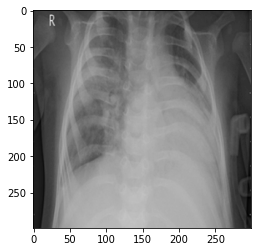

In [ ]:
ima = plt.imread("/content/COVID-19_Radiography_Dataset/Viral Pneumonia/Viral Pneumonia-352.png")
plt.imshow(ima,cmap='gray')
print(ima.shape)

(299, 299)


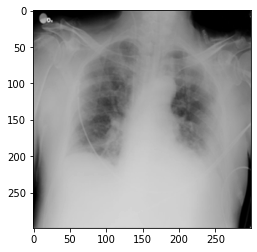

In [ ]:
ima = plt.imread("/content/COVID-19_Radiography_Dataset/COVID/COVID-1.png")
plt.imshow(ima,cmap='gray')
print(ima.shape)

# resize covid data

In [ ]:
images_path = os.listdir('/content/COVID-19_Radiography_Dataset/COVID/')
covid = []
for img_path in images_path:
  image = plt.imread("/content/COVID-19_Radiography_Dataset/COVID/"+img_path)
  covid.append(cv2.resize(image, (100, 100)).flatten())
covid = np.stack(covid,axis=0) 

In [ ]:
images_path = os.listdir('/content/COVID-19_Radiography_Dataset/Viral Pneumonia/')
pnemo = []
for img_path in images_path:
  image = plt.imread("/content/COVID-19_Radiography_Dataset/Viral Pneumonia/"+img_path)
  if image.flatten().shape[0]==89401:
    pnemo.append(cv2.resize(image, (100, 100)).flatten())
pnemo = np.stack(pnemo,axis=0)  

In [ ]:
print(covid.shape)
print(pnemo.shape)

(3616, 10000)
(1205, 10000)


# clients of data

In [ ]:
clients_X,clients_y,X_test,y_test = get_clients(covid, pnemo, n_clients = 3)

In [ ]:
# from sklearn import decomposition

# clients_X_pca = []

# for i in clients_X:
#   pca = decomposition.PCA(n_components=100)
#   pca.fit(i[0])
#   c1 = pca.transform(i[0])
#   pca = decomposition.PCA(n_components=100)
#   pca.fit(i[1])
#   c2 = pca.transform(i[1])
#   clients_X_pca.append([c1,c2])
# pca = decomposition.PCA(n_components=100)
# pca.fit(X_test)
# X_test_pca = pca.transform(X_test)  

In [ ]:
xtrain_gl, ytrain_gl = get_total_from_clients(clients_X,clients_y)

In [ ]:
clf = SVM(xtrain_gl, ytrain_gl, X_test, y_test, val=False, n_iters=1000,opt='batch_GD' )
clf.fit()
print(clf.accuracy())
print(clf.precision())
print(clf.recall())

96.8944099378882
95.6896551724138
91.73553719008265


In [ ]:
f_svm = Federated_SVM(n_clients = 3, val=False, n_iters=150,opt='batch_GD')
f_svm.create_clients(clients_X,clients_y,X_test,y_test)

f_svm.fit(20,f_svm.average_aggregator)

global round 1
client 1 92.2360248447205 96.64804469273743 71.48760330578511
client 2 89.54451345755695 72.10031347962382 95.0413223140496
client 3 93.99585921325053 94.23076923076923 80.99173553719008
global test acc pre rec 94.30641821946169 91.55555555555556 85.12396694214877
global round 2
client 1 92.13250517598344 96.62921348314607 71.07438016528926
client 2 93.2712215320911 81.2720848056537 95.0413223140496
client 3 94.824016563147 93.24324324324324 85.53719008264463
global test acc pre rec 95.13457556935818 92.95154185022027 87.19008264462809
global round 3
client 1 92.44306418219462 96.68508287292818 72.31404958677686
client 2 94.09937888198758 83.15412186379928 95.86776859504133
client 3 95.03105590062113 92.92035398230088 86.77685950413223
global test acc pre rec 95.54865424430642 92.7038626609442 89.25619834710744
global round 4
client 1 92.13250517598344 96.62921348314607 71.07438016528926
client 2 94.40993788819875 84.30656934306569 95.45454545454545
client 3 95.238095238